<h1> <center> EL7006 - Tarea Nº1 <br /> Redes Recurrentes y LSTM  </center> </h1>
<h3> <center>Profesor: Pablo Estévez <br />
Profesor Auxiliar: Jhon Intriago <br />
Ayudantes: Bastián Gamboa, Daniel Neira, Giovanni Castiglioni <br />
<h3><center>Semestre: Primavera 2023 </center></h3>

En esta tarea deberán contestar preguntas e implementar código relacionado a las redes neuronales recurrentes, en particular a las tipo Long Short-Term Memory (LSTM). Se recomienda leer el capítulo 10 de [Deep Learning Book](https://www.deeplearningbook.org/).

Para entregar su tarea, suba a u-cursos un archivo zip que contenga los notebooks de los problemas 1 y 2, desarrollados con sus respuestas e implementaciones, junto con cualquier archivo adicional necesario para ejecutarlos (excluyendo la base de datos). Sea claro en sus respuestas, y comente adecuadamente su código. No es necesario redactar un informe.

<h1><center><u>Problema 2: Procesamiento de voz usando RNN </u></center></h1>

En este problema, usted debe implementar y entrenar una red neuronal recurrente (RNN) para procesar señales de voz y predecir la palabra que mencionan. Debe comparar el desempeño obtenido al usar una Vanilla RNN y una LSTM RNN. Se les entrega todo el preprocesamiento de los datos en este notebook.

Si implementa sus modelos correctamente, debería obtener un accuracy en el rango 86-91 %.

<h2>Preliminares: Google Colab</h2>

Para evitar limitaciones de hardware, ejecute este notebook en Google Colab con GPU. Para ello siga estos pasos:

- Suba este notebook a su cuenta de Google Drive.
- Abra el notebook. Se hará automáticamente en Google Colab.
- En el menú "Entorno de ejecución", seleccione "Cambiar tipo de entorno de ejecución" y en "Acelerador por hardware" seleccione GPU.

Ejecute la siguiente celda para descargar la base de datos de este problema, crear la carpeta "speech_commands", y descomprimir la base de datos dentro de dicha carpeta.



In [ ]:
!wget https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz
!mkdir speech_commands
!tar -xf speech_commands_v0.02.tar.gz -C speech_commands

--2023-09-06 02:20:19--  https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.128.128, 142.251.6.128, 172.217.212.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.128.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2428923189 (2.3G) [application/gzip]
Saving to: ‘speech_commands_v0.02.tar.gz’

speech_commands_v0. 100%[===================>]   2.26G   238MB/s    in 19s     

2023-09-06 02:20:39 (122 MB/s) - ‘speech_commands_v0.02.tar.gz’ saved [2428923189/2428923189]



La celda anterior solo se necesita ejecutar la primera vez que conecta el notebook a un entorno de ejecución. En caso de dudas, puede inspeccionar los archivos que existen en su máquina asignada con la siguiente celda. Si la carpeta "speech_commands" ya existe, significa que ya existe la base de datos.

In [ ]:
!ls

sample_data  speech_commands  speech_commands_v0.02.tar.gz


Google Colab tiene preinstaladas casi todas las librerías que necesitamos, excepto una. Ejecute la siguiente celda para instalar la librería "python_speech_features" que nos permitirá procesar las señales de voz.

In [ ]:
!pip install python_speech_features

  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5870 sha256=87fa80cc8863607553c8911afb26c52314c1f8d3122ca527b3cf6e0ad77da2cf
  Stored in directory: /root/.cache/pip/wheels/5a/9e/68/30bad9462b3926c29e315df16b562216d12bdc215f4d240294
Successfully built python_speech_features


<h2>Librerías</h2>

In [ ]:
import os
import json
import time

import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from python_speech_features import mfcc
from scipy.io import wavfile

<h2>Procesamiento de voz con "Speech Commands Dataset"</h2>

La base de datos [Speech Commands](https://arxiv.org/abs/1804.03209) consiste en audios de un segundo de duración muestreados a 16kHz en donde diversas personas fueron grabadas diciendo comandos cortos en inglés. Incluye 10 comandos principales, algunas palabras irrelevantes, silencios, y ruidos de fondo. Su principal motivación es ser una puerta de entrada para experimentar con modelos de procesamiento de voz. El objetivo es detectar la pronunciación de una única palabra dentro de un pequeño conjunto de palabras posibles.

A continuación, puede escuchar un ejemplo de la clase "yes" y un ejemplo de la clase "no".

In [ ]:
demo_yes = "speech_commands/yes/0a2b400e_nohash_0.wav"
demo_no = "speech_commands/no/0a2b400e_nohash_0.wav"

In [ ]:
print("Example from class 'yes'")
ipd.Audio(demo_yes)

Example from class 'yes'


In [ ]:
print("Example from class 'no'")
ipd.Audio(demo_no)

Example from class 'no'


Normalmente, los modelos de procesamiento de voz no operan directamente sobre la señal de audio, sino que sobre una versión transformada de la misma que aprovecha el contenido localizado en diferentes bandas de frecuencia.

El método más común calcula [Mel-frequency Cepstrum Coefficients (MFCC)](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum). A grandes rasgos, se basa en segmentar la señal en varias ventanas consecutivas de ancho $winlen$ cuyos centros estas separados en $winstep$. En cada una de estas ventanas, se calculan coeficientes en base a la descomposición en frecuencia obtenida por la FFT.

Valores típicos para este dominio son ventanas de tamaño 25-40 milisegundos y separaciones que rondan el 50% del ancho. Además, en cada ventana se suelen calcular 13 coeficientes. Para disminuir el costo computacional, a lo largo de esta tarea se usa un ancho de ventana de 100 ms con paso de 50 ms. En consecuencia, cada señal de audio de 1 segundo se transforma en una secuencia de largo 19 en donde en cada paso existen 13 características.

A continuación, se grafican las señales de audio de los ejemplos escuchados anteriormente junto con sus MFCC.

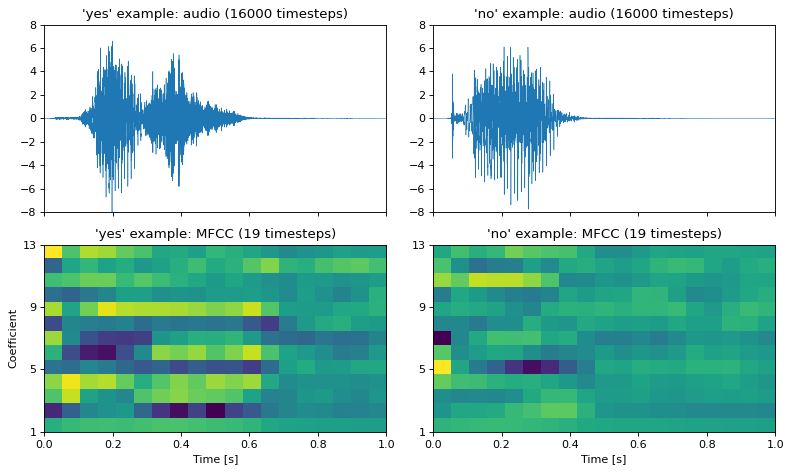

In [ ]:
# Load demo data
sr, audio_yes = wavfile.read(demo_yes)
sr, audio_no = wavfile.read(demo_no)
time_axis = np.arange(audio_yes.size) / sr

# Normalize audio to zero mean and unit variance
audio_yes = audio_yes.astype(np.float32)
audio_yes = (audio_yes - audio_yes.mean()) / audio_yes.std()
audio_no = audio_no.astype(np.float32)
audio_no = (audio_no - audio_no.mean()) / audio_no.std()

# Compute MFCC
winlen_ms = 100  # Window size, in miliseconds
winstep_ms = 0.5 * winlen_ms  # Step size for sliding window, in miliseconds
winlen = winlen_ms / 1000
winstep = winstep_ms / 1000
nfft = int(2 ** np.ceil(np.log2(sr * winlen)))  # Closest power of 2
mfcc_yes = mfcc(audio_yes, sr, winlen=winlen, winstep=winstep, numcep=13, nfft=nfft)
mfcc_no = mfcc(audio_no, sr, winlen=winlen, winstep=winstep, numcep=13, nfft=nfft)

# Plot audio and MFCC
fig, axes = plt.subplots(2, 2, figsize=(10, 6), dpi=80, sharex=True)
axes[0, 0].plot(time_axis, audio_yes, linewidth=0.5)
axes[0, 0].set_title("'yes' example: audio (%d timesteps)" % audio_yes.size)
axes[0, 0].set_xlim([0, 1])
axes[0, 0].set_ylim([-8, 8])
axes[0, 1].plot(time_axis, audio_no, linewidth=0.5)
axes[0, 1].set_title("'no' example: audio (%d timesteps)" % audio_no.size)
axes[0, 1].set_xlim([0, 1])
axes[0, 1].set_ylim([-8, 8])
axes[1, 0].imshow(mfcc_yes.T, interpolation="none", aspect="auto", extent=[0, 1, 1, 13], origin='lower')
axes[1, 0].set_xlabel("Time [s]")
axes[1, 0].set_title("'yes' example: MFCC (%d timesteps)" % mfcc_yes.shape[0])
axes[1, 0].set_ylabel("Coefficient")
axes[1, 0].set_yticks([1, 5, 9, 13])
axes[1, 1].imshow(mfcc_no.T, interpolation="none", aspect="auto", extent=[0, 1, 1, 13], origin='lower')
axes[1, 1].set_yticks([1, 5, 9, 13])
axes[1, 1].set_xlabel("Time [s]")
axes[1, 1].set_title("'no' example: MFCC (%d timesteps)" % mfcc_no.shape[0])
plt.tight_layout()
plt.show()

<h2>Preparación de los datos</h2>

Por simplicidad, se reducirá la base de datos a los 10 comandos principales. Es decir, cada ejemplo solo puede pertenecer a una de las siguientes clases: "down", "go", "left", "no", "off", "on", "right", "stop", "up", "yes". Por lo tanto, el modelo que implemente debe clasificar cada ejemplo en una de estas 10 posibles clases.

Tampoco se usarán perturbaciones de los datos para mejorar la generalización (data augmentation), tales como adición de ruido de fondo, pequeños cortes, desplazamientos del tono o dilataciones temporales, que son típicamente usadas en modelos del estado del arte.

Cada una de los 10 comandos mencionados anteriormente será asociado a una categoría numérica (etiqueta) que va del 0 al 9.

In [ ]:
DATASET_PATH = "speech_commands"
WORDS = ["down", "go", "left", "no", "off", "on", "right", "stop", "up", "yes"]
WORDS_LABEL = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

En primer lugar, se limpiarán los datos removiendo aquellos ejemplos con una duración inferior a 1 segundo.

In [ ]:
for word in WORDS:
    removed_files = 0
    folder_name = os.path.join(DATASET_PATH, word)
    files = os.listdir(folder_name)
    files = [f for f in files if ".wav" in f]
    for single_file in files:
        filepath = os.path.join(folder_name, single_file)
        this_fs, this_audio = wavfile.read(filepath)
        if this_audio.size < this_fs:
            os.remove(filepath)
            removed_files += 1
    print("Word '%s': %d files removed" % (word, removed_files))

Word 'down': 337 files removed
Word 'go': 402 files removed
Word 'left': 299 files removed
Word 'no': 396 files removed
Word 'off': 318 files removed
Word 'on': 374 files removed
Word 'right': 330 files removed
Word 'stop': 309 files removed
Word 'up': 454 files removed
Word 'yes': 352 files removed


Como siguiente paso, se dividirá la base de datos en los conjuntos de entrenamiento, validación y prueba. Esta división se hará identificando cada sujeto grabado y asignándolo a cada conjunto de forma aleatoria (pero reproducible fijando una semilla) para que el 80% de los sujetos sea de entrenamiento, el 10% de validación, y el restante 10% de prueba. De esta forma, el modelo se evaluará siempre en grabaciones de sujetos que no fueron escuchados previamente.

In [ ]:
train_fraction = 0.8
val_fraction = 0.1

# -----------------------------

# Fin and split subjects
subject_ids = []
for word in WORDS:
    folder_name = os.path.join(DATASET_PATH, word)
    files = os.listdir(folder_name)
    files = [f for f in files if ".wav" in f]
    # First string of filename is subject ID
    word_subject_ids = [f.split("_")[0] for f in files]
    word_subject_ids = np.unique(word_subject_ids)
    subject_ids.extend(word_subject_ids)
subject_ids = list(set(subject_ids))
subject_ids.sort()
# Random but reproducible shuffle of all subjects found in dataset
subject_ids = np.random.RandomState(seed=0).permutation(subject_ids)
n_subjects = len(subject_ids)
cut_train = int(train_fraction * n_subjects)
cut_val = int((train_fraction + val_fraction) * n_subjects)
train_subjects = subject_ids[:cut_train]
val_subjects = subject_ids[cut_train:cut_val]
test_subjects = subject_ids[cut_val:]

# File split based on subject split
split_dict = {'train': {}, 'val': {}, 'test': {}}
for word in WORDS:
    folder_name = os.path.join(DATASET_PATH, word)
    files = os.listdir(folder_name)
    files = [f for f in files if ".wav" in f]
    word_subject_ids = [f.split("_")[0] for f in files]
    n_files = len(files)
    word_train_files = [files[i] for i in range(n_files) if word_subject_ids[i] in train_subjects]
    word_val_files = [files[i] for i in range(n_files) if word_subject_ids[i] in val_subjects]
    word_test_files = [files[i] for i in range(n_files) if word_subject_ids[i] in test_subjects]
    print("'%s': Train %d - Val %d - Test %d" % (
        word, len(word_train_files), len(word_val_files), len(word_test_files)))
    split_dict['train'][word] = word_train_files
    split_dict['val'][word] = word_val_files
    split_dict['test'][word] = word_test_files

'down': Train 2805 - Val 413 - Test 362
'go': Train 2767 - Val 370 - Test 341
'left': Train 2779 - Val 373 - Test 350
'no': Train 2812 - Val 386 - Test 347
'off': Train 2741 - Val 349 - Test 337
'on': Train 2729 - Val 394 - Test 348
'right': Train 2756 - Val 370 - Test 322
'stop': Train 2829 - Val 402 - Test 332
'up': Train 2582 - Val 363 - Test 324
'yes': Train 2943 - Val 402 - Test 347


Finalmente, se procederá a calcular los MFCC de cada señal de audio de los conjuntos creados. Como se mencionó anteriormente, se usará un ancho de ventana de 100 ms, 50% de paso, y 13 coeficientes. Previo a calcular el MFCC, cada señal de audio $x$ se normaliza como:

$$ x \gets \frac{x - \mathrm{mean}(x)}{\mathrm{std}(x)}$$

In [ ]:
winlen_ms = 100  # Window size, in miliseconds
winstep_ms = 0.5 * winlen_ms  # Step size for sliding window, in miliseconds
numcep = 13  # Number of MFCC

# -------------------------------
set_names = list(split_dict.keys())
winlen = winlen_ms / 1000
winstep = winstep_ms / 1000
print("Using winlen %s [s] and winstep %s [s]" % (winlen, winstep))
start_time = time.time()
dataset_dict = {}
for set_name in set_names:
    set_mfcc = []
    set_labels = []
    print("Processing %s set" % set_name)
    for label, word in zip(WORDS_LABEL, WORDS):
        folder_name = os.path.join(DATASET_PATH, word)
        set_files = split_dict[set_name][word]
        word_mfcc = []
        for single_file in set_files:
            filepath = os.path.join(folder_name, single_file)
            file_fs, file_audio = wavfile.read(filepath)
            nfft = int(2 ** np.ceil(np.log2(file_fs * winlen)))
            file_audio = file_audio.astype(np.float32)
            file_audio = (file_audio - file_audio.mean()) / file_audio.std()
            file_mfcc = mfcc(
                file_audio, file_fs,
                winlen=winlen, winstep=winstep, numcep=numcep, nfft=nfft)
            file_mfcc = file_mfcc.astype(np.float32)
            word_mfcc.append(file_mfcc)
        word_mfcc = np.stack(word_mfcc, axis=0)
        n_examples = word_mfcc.shape[0]
        word_labels = n_examples * [label]
        word_labels = np.array(word_labels).astype(np.int32)
        set_mfcc.append(word_mfcc)
        set_labels.append(word_labels)
        elap_time = time.time() - start_time
        print("    class %d ('%s') done (E.T. %1.2f [s])" % (label, word, elap_time))
    set_mfcc = np.concatenate(set_mfcc, axis=0)
    set_labels = np.concatenate(set_labels, axis=0)
    dataset_dict[set_name] = {'x': set_mfcc, 'y': set_labels}
elap_time = time.time() - start_time
print("Data preparation done (E.T. %1.2f [s])" % elap_time)
for set_name in ['train', 'val', 'test']:
    np.savez(
        'win%d_%s.npz' % (winlen_ms, set_name),
        x=dataset_dict[set_name]['x'],
        y=dataset_dict[set_name]['y'])
    print("Checkpoint created win%d_%s.npz" % (winlen_ms, set_name))

Using winlen 0.1 [s] and winstep 0.05 [s]
Processing train set
    class 0 ('down') done (E.T. 28.15 [s])
    class 1 ('go') done (E.T. 43.01 [s])
    class 2 ('left') done (E.T. 57.40 [s])
    class 3 ('no') done (E.T. 71.45 [s])
    class 4 ('off') done (E.T. 84.96 [s])
    class 5 ('on') done (E.T. 98.41 [s])
    class 6 ('right') done (E.T. 112.05 [s])
    class 7 ('stop') done (E.T. 127.13 [s])
    class 8 ('up') done (E.T. 139.79 [s])
    class 9 ('yes') done (E.T. 154.19 [s])
Processing val set
    class 0 ('down') done (E.T. 156.11 [s])
    class 1 ('go') done (E.T. 158.14 [s])
    class 2 ('left') done (E.T. 160.83 [s])
    class 3 ('no') done (E.T. 162.52 [s])
    class 4 ('off') done (E.T. 164.05 [s])
    class 5 ('on') done (E.T. 165.81 [s])
    class 6 ('right') done (E.T. 167.44 [s])
    class 7 ('stop') done (E.T. 169.23 [s])
    class 8 ('up') done (E.T. 171.38 [s])
    class 9 ('yes') done (E.T. 174.04 [s])
Processing test set
    class 0 ('down') done (E.T. 175.64 [s]

<h2>Últimos ajustes de datos</h2>

Los conjuntos de entrenamiento, validación y prueba de secuencias de MFCC generados anteriormente son tres pares $(x, y)$ de arreglos numpy. Los arreglos de entrada ($x$) contienen números reales y poseen dimensiones [número de ejemplos, número de pasos, número de características]. Específicamente, poseen dimensiones [?, 19, 13]. Por otro lado, los arreglos de salida ($y$) contienen números enteros y poseen dimensiones [número de ejemplos,], en donde cada fila de $y$ contiene la etiqueta de la fila correspondiente en $x$.

Estos conjuntos fueron guardados en los archivos "win100_SETNAME.npz". No es necesario que vuelva a ejecutar la preparación de los datos si estos archivos ya existen en su máquina, ya que la siguiente celda carga los datos a partir de estos archivos.


In [ ]:
# Load from checkpoint
winlen_ms = 100
set_names = ['train', 'val', 'test']
verification = [os.path.isfile('win%d_%s.npz' % (winlen_ms, set_name)) for set_name in set_names]
exists_checkpoint = np.all(verification)
if exists_checkpoint:
    print("Checkpoint found.")
    dataset_dict = {}
    for set_name in set_names:
        set_data = np.load('win%d_%s.npz' % (winlen_ms, set_name))
        dataset_dict[set_name] = {'x': set_data['x'], 'y': set_data['y']}
        n_examples = dataset_dict[set_name]['y'].size
        n_classes = len(np.unique(dataset_dict[set_name]['y']))
        print("%s set with %d examples and %d classes" % (set_name, n_examples, n_classes))
else:
    raise FileNotFoundError("Some or all checkpoints were not found.")

# Unpacking arrays
x_train, y_train = dataset_dict['train']['x'], dataset_dict['train']['y']
x_val, y_val = dataset_dict['val']['x'], dataset_dict['val']['y']
x_test, y_test = dataset_dict['test']['x'], dataset_dict['test']['y']

Checkpoint found.
train set with 27743 examples and 10 classes
val set with 3822 examples and 10 classes
test set with 3410 examples and 10 classes


Estos datos se normalizarán usando las estadísticas del conjunto de entrenamiento. Cada una de las 13 características se normalizará por separado. Finalmente, el conjunto de entrenamiento se revolverá de forma aleatoria (pero reproducible fijando una semilla).

In [ ]:
# Normalize features with train statistics across all examples and timesteps
x_train_mean = x_train.mean(axis=(0, 1))  # Mean of each of the 13 features
x_train_std = x_train.std(axis=(0, 1))  # Std of each of the 13 features
x_train = (x_train - x_train_mean) / x_train_std
x_val = (x_val - x_train_mean) / x_train_std
x_test = (x_test - x_train_mean) / x_train_std

# # Random but reproducible shuffle of the training set
n_train_data = y_train.size
idx_permuted = np.random.RandomState(seed=0).permutation(range(n_train_data))
x_train = x_train[idx_permuted]
y_train = y_train[idx_permuted]

# Shape of data is [batch, timesteps, feats]
n_steps = x_train.shape[1]
n_feats = x_train.shape[2]
n_classes = len(np.unique(y_train))
print("%d timesteps, %d features, %d classes" % (n_steps, n_feats, n_classes))

19 timesteps, 13 features, 10 classes


<h2>Vanilla RNN: Implementación</h2>

Ahora que los datos han sido completamente preprocesados, usted debe implementar una red neuronal recurrente del tipo "vanilla" o básica para esta tarea de clasificación.

Sea $x=\{x_1, x_2, \ldots, x_T\}$ una secuencia de entrada de $T=19$ pasos y $F=13$ características por paso. Es decir, $x_k\in\mathbb{R}^F,\ k\in\{1,2,\ldots,T\}$. Sea $y\in\{0,1,\ldots,C-1\}$ la clase a la que pertenece la secuencia $x$, de $C=10$ clases posibles.

Se solicita implementar la siguiente RNN:

$$ h_0 = \vec{0}$$
$$ h_k = \tanh \left( W\begin{bmatrix}x_k\\h_{k-1}\end{bmatrix} + b \right),\ \ k\in\{1,2,\ldots, T\}$$
$$ z = W_zh_T+b_z$$
$$\hat{y} = \mathrm{argmax}(z)$$

Donde $h_k\in\mathbb{R}^H$ es el estado oculto, $H$ es la dimensionalidad de la capa recurrente, $h_0$ es un estado inicial nulo, $W$ y $b$ son los pesos y sesgos de la capa recurrente, $W_z$ y $b_z$ son los pesos y sesgos de la capa de salida, $z\in\mathbb{R}^C$ son los logits calculados a partir del último estado $h_T$, e $\hat{y}\in\{0,1,\ldots,C-1\}$ es la clase predicha por la RNN.

Especificaciones del modelo:
- Dimensionalidad $H=32$.
- Función de pérdida cross-entropy.
- Optimizador Adam con $\beta_{1}=0.9$ y $\beta_{2}=0.999$ (valores típicos).
- Entrenamiento por 200 épocas, validando en el conjunto de validación completo al final de cada época, con tamaño de batch 64.
- Al finalizar el entrenamiento se debe preservar el mejor modelo, definido como aquél de mínima cross-entropy de validación.

Instrucciones de programación:
- Es libre de elegir la librería de redes neuronales de su preferencia. Se recomienda Tensorflow o Pytorch.
- Independiente de la librería elegida, ustedes deben implementar las capas recurrentes. Es decir, para la arquitectura de la red neuronal solo se admite que usen de la librería capas fully-connected (nn.Linear en Pytorch, layers.Dense en Tensorflow), funciones de activación, y operaciones elementales como concatenación, suma, producto, multiplicación de matrices. Si lo desea, puede evitar usar capas fully-connected y simplemente crear y utilizar los pesos y sesgos directamente. Fuera de la implementación de las capas, es libre de usar todas las herramientas de la librería para construir el modelo y entrenarlo.
- Por simplicidad, se sugiere implementar la recurrencia con un ciclo for, pero no es obligatorio.
- Debe implementar su modelo en una clase llamada "ModelVanillaRNN".
- La clase debe implementar un método "fit" para entrenar en datos $(x_{train}$, $y_{train})$ y validar en datos $(x_{val}, y_{val})$. Al entrenar el modelo, se debe entregar la evolución de cross-entropy y accuracy a lo largo de las épocas.
- La clase debe implementar un método "evaluate" para evaluar el accuracy en datos $(x, y)$.
- Es libre de implementar métodos adicionales si lo desea.

Implemente su modelo en la siguiente celda. Sea ordenado y claro en su código. Comente adecuadamente. Elija nombres significativos para sus variables.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm


class ModelVanillaRNN(nn.Module):
    def __init__(
        self,
        learning_rate,
        n_input_features=13,
        n_input_steps=19,
        n_hidden_dimension=32,
        n_classes=10,
        batch_size=64,
        n_epochs=200
    ):
        super(ModelVanillaRNN, self).__init__()

        self.learning_rate = learning_rate
        self.n_input_features = n_input_features
        self.n_input_steps = n_input_steps
        self.n_hidden_dimension = n_hidden_dimension
        self.n_classes = n_classes
        self.batch_size = batch_size
        self.n_epochs = n_epochs

        # --- Your code goes here ---
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

        self.linear1=torch.nn.Linear(self.n_input_features+self.n_hidden_dimension,self.n_hidden_dimension)
        #output layer
        self.linear_output=torch.nn.Linear(self.n_hidden_dimension,self.n_classes)

    def forward(self, x):
      batch_size = x.shape[0]
      h_t = torch.zeros(batch_size, self.n_hidden_dimension)  # Initial hidden state
      for i in range(self.n_input_steps):
          x_t=x[:, i, :]
          xh=torch.concat((x_t,h_t),dim=1)
          h_t=torch.tanh(self.linear1(xh))
      out = self.linear_output(h_t)
      return out


    def fit(self, x_train, y_train, x_val, y_val,run):
        # --- Your code goes here ---
        x_train=torch.from_numpy(x_train)
        y_train=torch.from_numpy(y_train)
        x_val=torch.from_numpy(x_val)
        y_val=torch.from_numpy(y_val)

        # Define loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate,betas=(0.9, 0.999))

        # Initialize lists to store training and validation loss and accuracy
        train_loss_history = []
        train_acc_history = []
        val_loss_history = []
        val_acc_history = []

        min_val_loss=100
        best_epoch=-1
        for epoch in tqdm(range(self.n_epochs)):
            self.train()  # Set the model to training mode
            running_loss = 0.0
            correct_train = 0
            total_train = 0

            for i in range(0, len(x_train), self.batch_size):
                # Get a batch of training data
                inputs = x_train[i:i + self.batch_size]
                labels = y_train[i:i + self.batch_size]

                # Convert class labels to one-hot encodings
                one_hot_labels = torch.eye(self.n_classes)[labels]

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = self(inputs)

                #Crosentropyloss
                loss = criterion(outputs, one_hot_labels)

                # 4. Compte gradients gradients
                loss.backward()

                # 5. Adjust learnable parameters
                optimizer.step()

                # Compute training accuracy
                _, predicted = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

                # Accumulate the loss
                running_loss += loss.item()

            # Calculate training accuracy and loss
            train_accuracy = 100.0 * correct_train / total_train
            train_loss = running_loss / len(x_train)
            train_loss_history.append(train_loss)
            train_acc_history.append(train_accuracy)

           # Validation
            self.eval()  # Set the model to evaluation mode
            val_loss = 0.0
            correct_val = 0
            total_val = 0

            with torch.no_grad():
                for i in range(0, len(x_val), self.batch_size):
                    val_inputs = x_val[i:i + self.batch_size]
                    val_labels = y_val[i:i + self.batch_size]

                    one_hot_val_labels = torch.eye(self.n_classes)[val_labels]

                    val_outputs = self(val_inputs)
                    val_loss += criterion(val_outputs, one_hot_val_labels)

                    _, predicted_val = torch.max(val_outputs.data, 1)
                    total_val += val_labels.shape[0]
                    correct_val += (predicted_val == val_labels).sum().item()

            # Calculate validation accuracy and loss
            val_accuracy = 100.0 * correct_val / total_val
            val_loss = val_loss / len(x_val)
            val_loss_history.append(val_loss)
            val_acc_history.append(val_accuracy)

            if val_loss<min_val_loss:
              torch.save(self.state_dict(), f"bestrnnmodel_lr{self.learning_rate}_run{run}.pt")
              min_val_loss=val_loss
              best_epoch= epoch

            # Print epoch statistics
            #print(f'Epoch [{epoch+1}/{self.n_epochs}], '
            #      f'Training Loss: {train_loss:.4f}, Training Acc: {train_accuracy:.2f}%, '
            #     f'Validation Loss: {val_loss:.4f}, Validation Acc: {val_accuracy:.2f}%')

        # Return training curves
        training_curves = {
            'train_loss': train_loss_history,
            'train_acc': train_acc_history,
            'val_loss': val_loss_history,
            'val_acc': val_acc_history,
            'min_val_loss': min_val_loss,
            'best_epoch': best_epoch
        }
        return training_curves


    def evaluate(self, x, y):
        x=torch.from_numpy(x)
        y=torch.from_numpy(y)

        # Ensure your model is in evaluation mode
        self.eval()

        # Disable gradient computation for evaluation
        with torch.no_grad():
            # Forward pass to get predicted logits
            logits = self(x)

            # Convert logits to predicted class labels (argmax)
            predicted_labels = torch.argmax(logits, dim=1)

            # Compare predicted labels with ground truth labels
            correct_predictions = (predicted_labels == y).sum().item()

            # Calculate accuracy
            total_samples = x.shape[0]
            accuracy = 100*correct_predictions / total_samples

        return accuracy

<h2>Vanilla RNN: Entrenamiento</h2>

Con su modelo ya implementado, es hora de entrenar. Se solicita entrenar su modelo usando primero una tasa de aprendizaje 0.001 y luego una tasa de aprendizaje de 0.0005. En cada caso, debe entrenar su modelo 5 veces.

Usando estas 5 corridas, usted debe:
- Reportar el promedio y desviación estándar del accuracy en el conjunto de validación entregado por el mejor modelo de cada corrida.
- Reportar el promedio y desviación estándar del accuracy en el conjunto de prueba entregado por el mejor modelo de cada corrida.
- Graficar las 5 curvas de cross-entropy de validación superpuestas, destacando en cada una la iteración en donde se encontró el mejor modelo (mínima pérdida de validación).
- Graficar las 5 curvas de accuracy de validación superpuestas, destacando en cada una la iteración en donde se encontró el mejor modelo (mínima pérdida de validación).

In [ ]:
learning_rate = 0.001

vanilla_rnn_training_curves_list = []
vanilla_rnn_val_accuracy_list = []
vanilla_rnn_test_accuracy_list = []
for i in range(5):
    # Create model
    my_rnn = ModelVanillaRNN(learning_rate=learning_rate)
    # Train model
    print(f"run: {i}")
    training_curves = my_rnn.fit(x_train, y_train, x_val, y_val,i)
    print(f"best epoch: {training_curves['best_epoch']},min val_loss: {training_curves['min_val_loss']}")
    # Evaluate model
    my_rnn.load_state_dict(torch.load(f'bestrnnmodel_lr{learning_rate}_run{i}.pt'))
    val_accuracy = my_rnn.evaluate(x_val, y_val)
    test_accuracy = my_rnn.evaluate(x_test, y_test)
    # Save reports for later
    vanilla_rnn_training_curves_list.append(training_curves)
    vanilla_rnn_val_accuracy_list.append(val_accuracy)
    vanilla_rnn_test_accuracy_list.append(test_accuracy)
print("Learning rate: %s" % learning_rate)
print("Validation accuracy: %1.1f \u00B1 %1.1f %%" % (
    np.mean(vanilla_rnn_val_accuracy_list),
    np.std(vanilla_rnn_val_accuracy_list)))
print("Test accuracy: %1.1f \u00B1 %1.1f %%" % (
    np.mean(vanilla_rnn_test_accuracy_list),
    np.std(vanilla_rnn_test_accuracy_list)))

run: 0


100%|██████████| 200/200 [06:45<00:00,  2.03s/it]


best epoch: 149,min val_loss: 0.007096896413713694
run: 1


100%|██████████| 200/200 [06:45<00:00,  2.03s/it]


best epoch: 169,min val_loss: 0.007360463961958885
run: 2


100%|██████████| 200/200 [06:44<00:00,  2.02s/it]


best epoch: 91,min val_loss: 0.006953829433768988
run: 3


100%|██████████| 200/200 [06:39<00:00,  2.00s/it]


best epoch: 179,min val_loss: 0.007205873727798462
run: 4


100%|██████████| 200/200 [06:36<00:00,  1.98s/it]

best epoch: 134,min val_loss: 0.006624178495258093
Learning rate: 0.001
Validation accuracy: 87.1 ± 0.3 %
Test accuracy: 85.1 ± 0.6 %


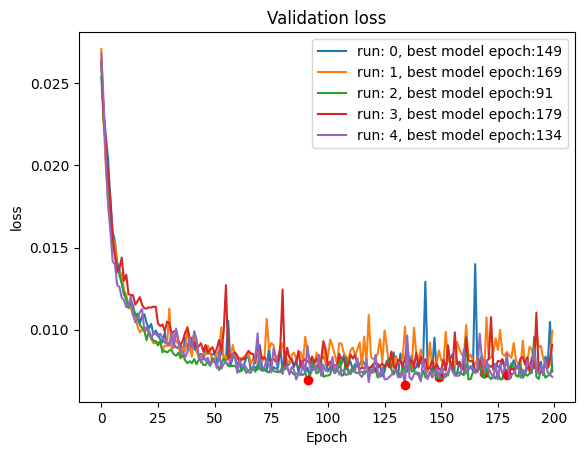

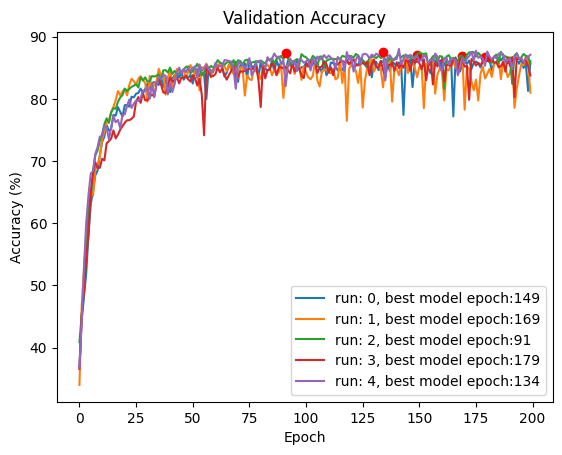

In [ ]:
# --- Your plots go here ---
for i in range(5):
  best_epoch=vanilla_rnn_training_curves_list[i]['best_epoch']
  plt.plot(vanilla_rnn_training_curves_list[i]['val_loss'],label=f'run: {i}, best model epoch:{best_epoch}')
  plt.plot(vanilla_rnn_training_curves_list[i]['best_epoch'],vanilla_rnn_training_curves_list[i]['val_loss'][best_epoch],'ro')
plt.title("Validation loss")
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

for i in range(5):
  best_epoch=vanilla_rnn_training_curves_list[i]['best_epoch']
  plt.plot(vanilla_rnn_training_curves_list[i]['val_acc'],label=f'run: {i}, best model epoch:{best_epoch}')
  plt.plot(vanilla_rnn_training_curves_list[i]['best_epoch'],vanilla_rnn_training_curves_list[i]['val_acc'][best_epoch],'ro')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

In [ ]:
learning_rate = 0.0005

vanilla_rnn_training_curves_list = []
vanilla_rnn_val_accuracy_list = []
vanilla_rnn_test_accuracy_list = []
for i in range(5):
    # Create model
    my_rnn = ModelVanillaRNN(learning_rate=learning_rate)
    # Train model
    print(f"run: {i}")
    training_curves = my_rnn.fit(x_train, y_train, x_val, y_val,i)
    print(f"best epoch: {training_curves['best_epoch']},min val_loss: {training_curves['min_val_loss']}")
    # Evaluate model
    my_rnn.load_state_dict(torch.load(f'bestrnnmodel_lr{learning_rate}_run{i}.pt'))
    val_accuracy = my_rnn.evaluate(x_val, y_val)
    test_accuracy = my_rnn.evaluate(x_test, y_test)
    # Save reports for later
    vanilla_rnn_training_curves_list.append(training_curves)
    vanilla_rnn_val_accuracy_list.append(val_accuracy)
    vanilla_rnn_test_accuracy_list.append(test_accuracy)
print("Learning rate: %s" % learning_rate)
print("Validation accuracy: %1.1f \u00B1 %1.1f %%" % (
    np.mean(vanilla_rnn_val_accuracy_list),
    np.std(vanilla_rnn_val_accuracy_list)))
print("Test accuracy: %1.1f \u00B1 %1.1f %%" % (
    np.mean(vanilla_rnn_test_accuracy_list),
    np.std(vanilla_rnn_test_accuracy_list)))

run: 0


100%|██████████| 200/200 [06:36<00:00,  1.98s/it]


best epoch: 188,min val_loss: 0.007497504819184542
run: 1


100%|██████████| 200/200 [06:38<00:00,  1.99s/it]


best epoch: 196,min val_loss: 0.006878420244902372
run: 2


100%|██████████| 200/200 [06:38<00:00,  1.99s/it]


best epoch: 179,min val_loss: 0.006664730142802
run: 3


100%|██████████| 200/200 [06:39<00:00,  2.00s/it]


best epoch: 198,min val_loss: 0.007037747651338577
run: 4


100%|██████████| 200/200 [06:38<00:00,  1.99s/it]

best epoch: 195,min val_loss: 0.006830169819295406
Learning rate: 0.0005
Validation accuracy: 86.8 ± 0.5 %
Test accuracy: 84.9 ± 0.4 %


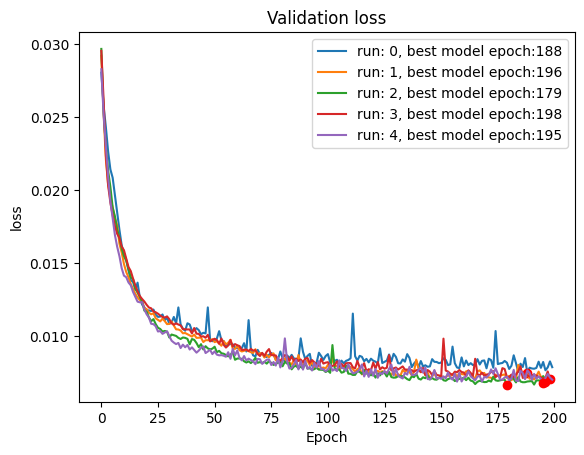

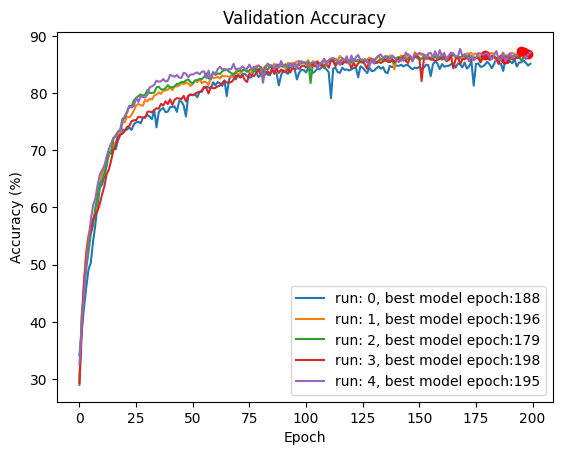

In [ ]:
# --- Your plots go here ---
for i in range(5):
  best_epoch=vanilla_rnn_training_curves_list[i]['best_epoch']
  plt.plot(vanilla_rnn_training_curves_list[i]['val_loss'],label=f'run: {i}, best model epoch:{best_epoch}')
  plt.plot(vanilla_rnn_training_curves_list[i]['best_epoch'],vanilla_rnn_training_curves_list[i]['val_loss'][best_epoch],'ro')
plt.title("Validation loss")
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

for i in range(5):
  best_epoch=vanilla_rnn_training_curves_list[i]['best_epoch']
  plt.plot(vanilla_rnn_training_curves_list[i]['val_acc'],label=f'run: {i}, best model epoch:{best_epoch}')
  plt.plot(vanilla_rnn_training_curves_list[i]['best_epoch'],vanilla_rnn_training_curves_list[i]['val_acc'][best_epoch],'ro')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

<h2>LSTM RNN: Implementación</h2>

Ahora usted debe implementar una red neuronal recurrente del tipo LSTM.

Se solicita implementar la siguiente RNN usando la capa LSTM típica (sin "peepholes connections"):

$$ h_0 = \vec{0}$$
$$ c_0 = \vec{0}$$
$$ h_k, c_k = \mathrm{LSTM}(x_k, h_{k-1}, c_{k-1}),\ \ k\in\{1,2,\ldots, T\}$$
$$ z = W_zh_T+b_z$$
$$\hat{y} = \mathrm{argmax}(z)$$

Donde $h_k,\ c_k\in\mathbb{R}^H$ son respectivamente el estado oculto y la memoria, $H$ es la dimensionalidad de la capa recurrente, $h_0,\ c_0$ son estados iniciales nulos, $W_z$ y $b_z$ son los pesos y sesgos de la capa de salida, $z\in\mathbb{R}^C$ son los logits calculados a partir del último estado $h_T$, e $\hat{y}\in\{0,1,\ldots,C-1\}$ es la clase predicha por la RNN.

Las especificaciones del modelo y las instrucciones de programación son las mismas que las entregadas para el modelo vanilla RNN, a excepción del nombre de la clase que debe ser "ModelLSTM".

Siguiendo buenas prácticas, debe inicializar los sesgos de la compuerta de olvido (forget gate) en 1.

Implemente su modelo en la siguiente celda. Sea ordenado y claro en su código. Comente adecuadamente. Elija nombres significativos para sus variables.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from tqdm import tqdm


class ModelLSTM(nn.Module):
    def __init__(
        self,
        learning_rate,
        n_input_features=13,
        n_input_steps=19,
        n_hidden_dimension=32,
        n_classes=10,
        batch_size=64,
        n_epochs=200
    ):
        super(ModelLSTM, self).__init__()
        self.learning_rate = learning_rate
        self.n_input_features = n_input_features
        self.n_input_steps = n_input_steps
        self.n_hidden_dimension = n_hidden_dimension
        self.n_classes = n_classes
        self.batch_size = batch_size
        self.n_epochs = n_epochs

        # --- Your code goes here ---

        #ft
        self.linear_ft=torch.nn.Linear(self.n_input_features+self.n_hidden_dimension,self.n_hidden_dimension)
        init_bias=torch.nn.Parameter(torch.ones(n_hidden_dimension))
        self.linear_ft.bias=init_bias

        #it
        self.linear_it=torch.nn.Linear(self.n_input_features+self.n_hidden_dimension,self.n_hidden_dimension)
        #hatc
        self.linear_hat_ct=torch.nn.Linear(self.n_input_features+self.n_hidden_dimension,self.n_hidden_dimension)
        #ot
        self.linear_ot=torch.nn.Linear(self.n_input_features+self.n_hidden_dimension,self.n_hidden_dimension)
        #output
        self.linear_output=torch.nn.Linear(self.n_hidden_dimension,self.n_classes)

    def forward(self, x):
      batch_size = x.shape[0]
      h_0 = torch.zeros(batch_size, self.n_hidden_dimension)
      c_0 = torch.zeros(batch_size, self.n_hidden_dimension)

      h_t,c_t=(h_0,c_0)

      for i in range(self.n_input_steps):
          x_t=x[:, i, :]
          xh=torch.concat((x_t,h_t),dim=1)
          f_t=torch.sigmoid(self.linear_ft(xh))
          i_t=torch.sigmoid(self.linear_it(xh))
          hat_c_t=torch.tanh(self.linear_hat_ct(xh))
          c_t=f_t*c_t+i_t*hat_c_t
          o_t=torch.sigmoid(self.linear_ot(xh))
          h_t=o_t*torch.tanh(c_t)
      out = self.linear_output(h_t)
      return out

    def fit(self, x_train, y_train, x_val, y_val,run):
        # --- Your code goes here ---
        x_train=torch.from_numpy(x_train)
        y_train=torch.from_numpy(y_train)
        x_val=torch.from_numpy(x_val)
        y_val=torch.from_numpy(y_val)

        # Define loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate,betas=(0.9, 0.999))

        # Initialize lists to store training and validation loss and accuracy
        train_loss_history = []
        train_acc_history = []
        val_loss_history = []
        val_acc_history = []

        min_val_loss=100
        best_epoch=-1

        for epoch in tqdm(range(self.n_epochs)):
            self.train()  # Set the model to training mode
            running_loss = 0.0
            correct_train = 0
            total_train = 0

            for i in range(0, len(x_train), self.batch_size):
                # Get a batch of training data
                inputs = x_train[i:i + self.batch_size]
                labels = y_train[i:i + self.batch_size]

                # Convert class labels to one-hot encodings
                one_hot_labels = torch.eye(self.n_classes)[labels]

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = self(inputs)

                #Crosentropyloss
                loss = criterion(outputs, one_hot_labels)

                # 4. Compte gradients gradients
                loss.backward()

                # 5. Adjust learnable parameters
                optimizer.step()

                # Compute training accuracy
                _, predicted = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

                # Accumulate the loss
                running_loss += loss.item()

            # Calculate training accuracy and loss
            train_accuracy = 100.0 * correct_train / total_train
            train_loss = running_loss / len(x_train)
            train_loss_history.append(train_loss)
            train_acc_history.append(train_accuracy)

           # Validation
            self.eval()  # Set the model to evaluation mode
            val_loss = 0.0
            correct_val = 0
            total_val = 0


            with torch.no_grad():
                for i in range(0, len(x_val), self.batch_size):
                    val_inputs = x_val[i:i + self.batch_size]
                    val_labels = y_val[i:i + self.batch_size]

                    one_hot_val_labels = torch.eye(self.n_classes)[val_labels]

                    val_outputs = self(val_inputs)
                    val_loss += criterion(val_outputs, one_hot_val_labels)

                    _, predicted_val = torch.max(val_outputs.data, 1)
                    total_val += val_labels.shape[0]
                    correct_val += (predicted_val == val_labels).sum().item()

            # Calculate validation accuracy and loss
            val_accuracy = 100.0 * correct_val / total_val
            val_loss = val_loss / len(x_val)
            val_loss_history.append(val_loss)
            val_acc_history.append(val_accuracy)

            if val_loss<min_val_loss:
              torch.save(self.state_dict(), f"bestlstmmodel_lr{self.learning_rate}_run{run}.pt")
              min_val_loss=val_loss
              best_epoch= epoch
            # Print epoch statistics
            #print(f'Epoch [{epoch+1}/{self.n_epochs}], '
            #      f'Training Loss: {train_loss:.4f}, Training Acc: {train_accuracy:.2f}%, '
            #     f'Validation Loss: {val_loss:.4f}, Validation Acc: {val_accuracy:.2f}%')

        # Return training curves
        training_curves = {
            'train_loss': train_loss_history,
            'train_acc': train_acc_history,
            'val_loss': val_loss_history,
            'val_acc': val_acc_history,
            'min_val_loss': min_val_loss,
            'best_epoch': best_epoch
        }

        return training_curves


    def evaluate(self, x, y):
        x=torch.from_numpy(x)
        y=torch.from_numpy(y)

        # Ensure your model is in evaluation mode
        self.eval()

        # Disable gradient computation for evaluation
        with torch.no_grad():
            # Forward pass to get predicted logits
            logits = self(x)

            # Convert logits to predicted class labels (argmax)
            predicted_labels = torch.argmax(logits, dim=1)

            # Compare predicted labels with ground truth labels
            correct_predictions = (predicted_labels == y).sum().item()

            # Calculate accuracy
            total_samples = x.shape[0]
            accuracy = 100*correct_predictions / total_samples

        return accuracy

<h2>LSTM RNN: Entrenamiento</h2>

Entrene su modelo LSTM con las mismas instrucciones entregadas para vanilla RNN.

In [ ]:
learning_rate = 0.001

lstm_rnn_training_curves_list = []
lstm_rnn_val_accuracy_list = []
lstm_rnn_test_accuracy_list = []
for i in range(5):
    # Create model
    my_rnn = ModelLSTM(learning_rate=learning_rate)
    # Train model
    print(f"run: {i}")
    training_curves = my_rnn.fit(x_train, y_train, x_val, y_val,i)
    print(f"best epoch: {training_curves['best_epoch']}, min val_loss: {training_curves['min_val_loss']}")
    # Evaluate model
    my_rnn.load_state_dict(torch.load(f'bestlstmmodel_lr{learning_rate}_run{i}.pt'))
    val_accuracy = my_rnn.evaluate(x_val, y_val)
    test_accuracy = my_rnn.evaluate(x_test, y_test)
    # Save reports for later
    lstm_rnn_training_curves_list.append(training_curves)
    lstm_rnn_val_accuracy_list.append(val_accuracy)
    lstm_rnn_test_accuracy_list.append(test_accuracy)
print("Learning rate: %s" % learning_rate)
print("Validation accuracy: %1.1f \u00B1 %1.1f %%" % (
    np.mean(lstm_rnn_val_accuracy_list),
    np.std(lstm_rnn_val_accuracy_list)))
print("Test accuracy: %1.1f \u00B1 %1.1f %%" % (
    np.mean(lstm_rnn_test_accuracy_list),
    np.std(lstm_rnn_test_accuracy_list)))

run: 0


100%|██████████| 200/200 [14:56<00:00,  4.48s/it]


best epoch: 19, min val_loss: 0.005195083562284708
run: 1


100%|██████████| 200/200 [14:52<00:00,  4.46s/it]


best epoch: 23, min val_loss: 0.0050829388201236725
run: 2


100%|██████████| 200/200 [14:55<00:00,  4.48s/it]


best epoch: 25, min val_loss: 0.004884140100330114
run: 3


100%|██████████| 200/200 [14:56<00:00,  4.48s/it]


best epoch: 15, min val_loss: 0.00515251699835062
run: 4


100%|██████████| 200/200 [15:03<00:00,  4.52s/it]

best epoch: 13, min val_loss: 0.00493933679535985
Learning rate: 0.001
Validation accuracy: 89.9 ± 0.2 %
Test accuracy: 88.1 ± 0.4 %
dict_keys(['train_loss', 'train_acc', 'val_loss', 'val_acc', 'min_val_loss', 'best_epoch'])


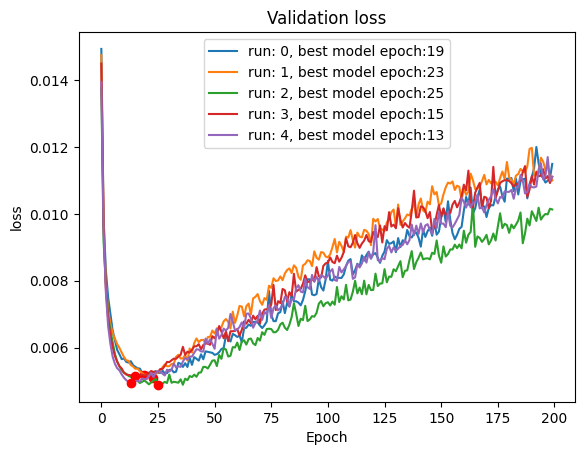

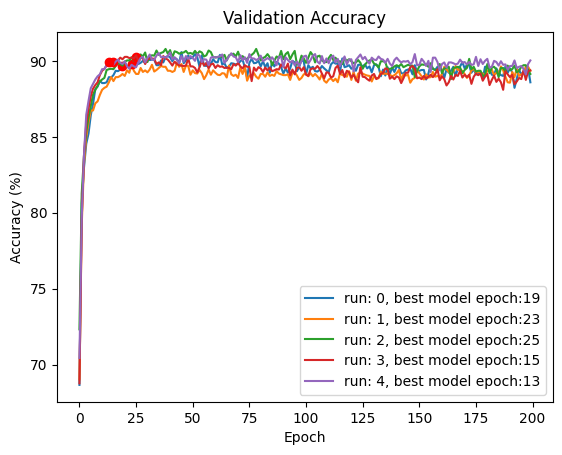

In [ ]:
# --- Your plots go here ---
for i in range(5):
  best_epoch=lstm_rnn_training_curves_list[i]['best_epoch']
  plt.plot(lstm_rnn_training_curves_list[i]['val_loss'],label=f'run: {i}, best model epoch:{best_epoch}')
  plt.plot(lstm_rnn_training_curves_list[i]['best_epoch'],lstm_rnn_training_curves_list[i]['val_loss'][best_epoch],'ro')
plt.title("Validation loss")
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

for i in range(5):
  best_epoch=lstm_rnn_training_curves_list[i]['best_epoch']
  plt.plot(lstm_rnn_training_curves_list[i]['val_acc'],label=f'run: {i}, best model epoch:{best_epoch}')
  plt.plot(lstm_rnn_training_curves_list[i]['best_epoch'],lstm_rnn_training_curves_list[i]['val_acc'][best_epoch],'ro')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

In [ ]:
learning_rate = 0.0005

lstm_rnn_training_curves_list = []
lstm_rnn_val_accuracy_list = []
lstm_rnn_test_accuracy_list = []
for i in range(5):
    # Create model
    my_rnn = ModelLSTM(learning_rate=learning_rate)
    # Train model
    print(f"run: {i}")
    training_curves = my_rnn.fit(x_train, y_train, x_val, y_val,i)
    print(f"best epoch: {training_curves['best_epoch']}, min val_loss: {training_curves['min_val_loss']}")
    # Evaluate model
    my_rnn.load_state_dict(torch.load(f'bestlstmmodel_lr{learning_rate}_run{i}.pt'))
    val_accuracy = my_rnn.evaluate(x_val, y_val)
    test_accuracy = my_rnn.evaluate(x_test, y_test)
    # Save reports for later
    lstm_rnn_training_curves_list.append(training_curves)
    lstm_rnn_val_accuracy_list.append(val_accuracy)
    lstm_rnn_test_accuracy_list.append(test_accuracy)
print("Learning rate: %s" % learning_rate)
print("Validation accuracy: %1.1f \u00B1 %1.1f %%" % (
    np.mean(lstm_rnn_val_accuracy_list),
    np.std(lstm_rnn_val_accuracy_list)))
print("Test accuracy: %1.1f \u00B1 %1.1f %%" % (
    np.mean(lstm_rnn_test_accuracy_list),
    np.std(lstm_rnn_test_accuracy_list)))

run: 0


100%|██████████| 200/200 [14:21<00:00,  4.31s/it]


best epoch: 45, min val_loss: 0.005069329869002104
run: 1


100%|██████████| 200/200 [14:01<00:00,  4.21s/it]


best epoch: 31, min val_loss: 0.005137684289366007
run: 2


100%|██████████| 200/200 [14:00<00:00,  4.20s/it]


best epoch: 36, min val_loss: 0.004848203156143427
run: 3


100%|██████████| 200/200 [14:02<00:00,  4.21s/it]


best epoch: 48, min val_loss: 0.0055437334813177586
run: 4


100%|██████████| 200/200 [14:06<00:00,  4.23s/it]

best epoch: 34, min val_loss: 0.005253883078694344
Learning rate: 0.0005
Validation accuracy: 89.9 ± 0.5 %
Test accuracy: 88.2 ± 0.6 %


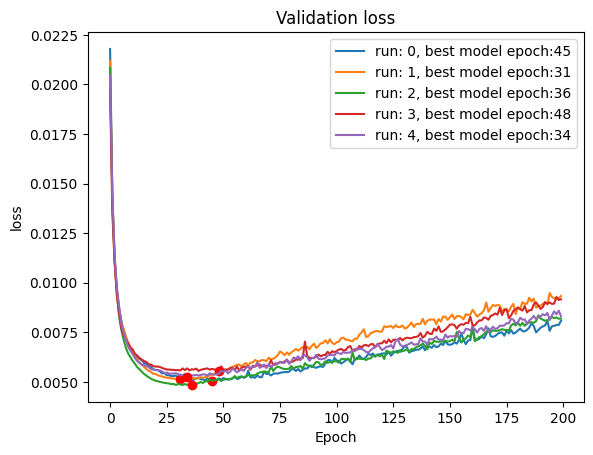

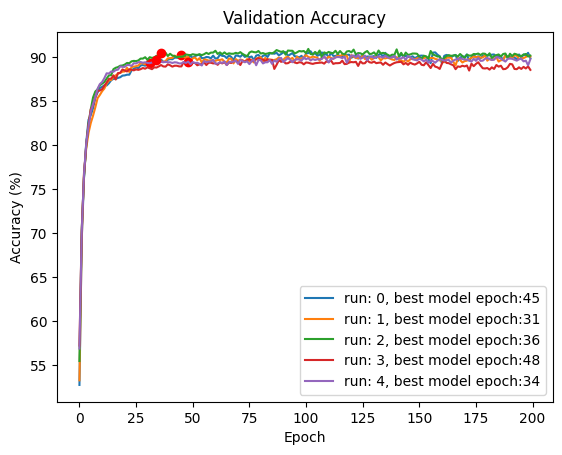

In [ ]:
# --- Your plots go here ---
for i in range(5):
  best_epoch=lstm_rnn_training_curves_list[i]['best_epoch']
  plt.plot(lstm_rnn_training_curves_list[i]['val_loss'],label=f'run: {i}, best model epoch:{best_epoch}')
  plt.plot(lstm_rnn_training_curves_list[i]['best_epoch'],lstm_rnn_training_curves_list[i]['val_loss'][best_epoch],'ro')
plt.title("Validation loss")
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

for i in range(5):
  best_epoch=lstm_rnn_training_curves_list[i]['best_epoch']
  plt.plot(lstm_rnn_training_curves_list[i]['val_acc'],label=f'run: {i}, best model epoch:{best_epoch}')
  plt.plot(lstm_rnn_training_curves_list[i]['best_epoch'],lstm_rnn_training_curves_list[i]['val_acc'][best_epoch],'ro')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

<h2>Análisis de resultados</h2>

Responda las siguientes preguntas en base a sus resultados.

1) Indique la mejor tasa de aprendizaje para cada arquitectura. ¿Existen diferencias significativas en el entrenamiento al cambiar la tasa de aprendizaje? ¿Cuál arquitectura es más estable? Explique diferencias en base a sus conocimientos teóricos.

Respuesta:

En el caso de la arquitectura Vanilla RNN la mejor tasa de aprendizaje es de 0.001, En el caso de la arquitectura LSTM la mejor tasa de aprendizaje es de 0.0005. Las diferencias con respecto a la tasa de aprendizaje son más notorias en la arquitectura Vanilla LSTM. En el entrenamiento se observa que con la tasa más baja se logra una convergencia al mejor modelo de forma más tardía, pero el accuracy y loss en validación son más estables y las oscilaciones más bajas.

2) Compare Vanilla RNN y LSTM en términos del desempeño alcanzado, el costo computacional, el número de iteraciones necesarias para encontrar el mejor modelo, y la sensibilidad a la inicialización de la red ¿Cuál arquitectura es más fácil de entrenar? Explique diferencias en base a sus conocimientos teóricos.

Respuesta:

**Vanilla RNN:**

run: 0
100%|██████████| 200/200 [06:45<00:00,  2.03s/it]
best epoch: 149, min val_loss: 0.007096896413713694

run: 1
100%|██████████| 200/200 [06:45<00:00,  2.03s/it]
best epoch: 169, min val_loss: 0.007360463961958885

run: 2
100%|██████████| 200/200 [06:44<00:00,  2.02s/it]
best epoch: 91, min val_loss: 0.006953829433768988

run: 3
100%|██████████| 200/200 [06:39<00:00,  2.00s/it]
best epoch: 179, min val_loss: 0.007205873727798462

run: 4
100%|██████████| 200/200 [06:36<00:00,  1.98s/it]
best epoch: 134, min val_loss: 0.006624178495258093

Learning rate: 0.001
Validation accuracy: 87.1 ± 0.3%
Test accuracy: 85.1 ± 0.6%

run: 0
100%|██████████| 200/200 [06:36<00:00,  1.98s/it]
best epoch: 188, min val_loss: 0.007497504819184542

run: 1
100%|██████████| 200/200 [06:38<00:00,  1.99s/it]
best epoch: 196, min val_loss: 0.006878420244902372

run: 2
100%|██████████| 200/200 [06:38<00:00,  1.99s/it]
best epoch: 179, min val_loss: 0.006664730142802

run: 3
100%|██████████| 200/200 [06:39<00:00,  2.00s/it]
best epoch: 198, min val_loss: 0.007037747651338577

run: 4
100%|██████████| 200/200 [06:38<00:00,  1.99s/it]
best epoch: 195, min val_loss: 0.006830169819295406

Learning rate: 0.0005
Validation accuracy: 86.8 ± 0.5%
Test accuracy: 84.9 ± 0.4%

**LSTM RNN:**

run: 0
100%|██████████| 200/200 [14:56<00:00,  4.48s/it]
best epoch: 19, min val_loss: 0.005195083562284708

run: 1
100%|██████████| 200/200 [14:52<00:00,  4.46s/it]
best epoch: 23, min val_loss: 0.0050829388201236725

run: 2
100%|██████████| 200/200 [14:55<00:00,  4.48s/it]
best epoch: 25, min val_loss: 0.004884140100330114

run: 3
100%|██████████| 200/200 [14:56<00:00,  4.48s/it]
best epoch: 15, min val_loss: 0.00515251699835062

run: 4
100%|██████████| 200/200 [15:03<00:00,  4.52s/it]
best epoch: 13, min val_loss: 0.00493933679535985

Learning rate: 0.001
Validation accuracy: 89.9 ± 0.2%
Test accuracy: 88.1 ± 0.4%

run: 0
100%|██████████| 200/200 [14:21<00:00,  4.31s/it]
best epoch: 45, min val_loss: 0.005069329869002104

run: 1
100%|██████████| 200/200 [14:01<00:00,  4.21s/it]
best epoch: 31, min val_loss: 0.005137684289366007

run: 2
100%|██████████| 200/200 [14:00<00:00,  4.20s/it]
best epoch: 36, min val_loss: 0.004848203156143427

run: 3
100%|██████████| 200/200 [14:02<00:00,  4.21s/it]
best epoch: 48, min val_loss: 0.0055437334813177586

run: 4
100%|██████████| 200/200 [14:06<00:00,  4.23s/it]
best epoch: 34, min val_loss: 0.005253883078694344

Learning rate: 0.0005
Validation accuracy: 89.9 ± 0.5%
Test accuracy: 88.2 ± 0.6%


El desempeño alcanzado por LSTM en esta experiencia es mejor que el de Vanilla RNN, pero esto va acompañado de un mayor costo computacional, las 200 épocas de entrenamiento para LSTM toman un tiempo que ronda los 15 minutos, mientras que en Vanilla RNN este mismo valor ronda los 7 minutos, es decir menos de la mitad. La cantidad de iteraciones necesarias para encontrar el mejor modelo difiere de forma radical para ambos modelos, en LSTM el mayor numero de iteraciones para encontrar el mejor modelo fue 45 con learning_rate = 0.0005, en el caso de Vanilla RNN el menor numero de iteraciones para encontrar el mejor modelo fue 91 con learning_rate = 0.001.La sensibildad a la inicialización se observa en los graficos en los que se puede ver que en algunas iteraciones Vanilla RNN tiene unos saltos en los valores de performance muy marcados con respecto a las otras iteraciones en la misma época, además la forma de convergencia varía. en LSTM se observa una convergencia más parecida para cada iteración.
La arquitectura LSTM (Long Short-Term Memory) es generalmente más estable en comparación con Vanilla RNN (Redes Neuronales Recurrentes básicas) debido a su capacidad para abordar problemas de gradientes que desaparecen o explotan.

Las redes Vanilla RNN a menudo experimentan problemas de inestabilidad durante el entrenamiento debido a la propagación de gradientes a lo largo de secuencias largas. Estos gradientes pueden volverse muy pequeños (gradientes que desaparecen) o muy grandes (gradientes que explotan), lo que dificulta el entrenamiento efectivo de la red y puede llevar a resultados incoherentes.

Por otro lado, LSTM incorpora compuertas como la compuerta de olvido que le permite controlar y regular el flujo de información a través de las unidades de memoria a lo largo de las secuencias.

3) El sobre-ajuste refleja que el modelo tiene una gran capacidad con respecto a la base de datos, ya que es capaz de memorizar los datos de entrenamiento de forma relativamente fácil ¿En qué arquitectura es posible observar sobre-ajuste? ¿Por qué una arquitectura se logra sobre-ajustar y la otra no? ¿Qué sugeriría para aprovechar la mayor capacidad del modelo que se logra sobre-ajustar y mejorar el desempeño, sin modificar el tamaño de sus capas neuronales?

Respuesta:

Se observa sobre-ajuste en la arquitectura LSTM, esto se observa en un empeoramiento en las métricas de evaluación después del mejor resultado, lo cual ocurre en una fase temprana del entrenamiento. LSTM tienen una estructura interna más compleja con unidades de memoria a largo plazo y a corto plazo. Esto le permite almacenar información relevante durante más tiempo en comparación con RNN Vanilla, que solo tienen una única unidad de estado oculto. En problemas complejos, esta capacidad de almacenamiento a largo plazo puede ser ventajosa, pero también puede conducir al sobreajuste si no se regula adecuadamente. La LSTM es una arquitectura más compleja en comparación con la RNN Vanilla. Esto significa que tiene más parámetros y, por lo tanto, una mayor capacidad para ajustarse a los datos de entrenamiento. Para evitar que la LSTM sobreajuste sin modificar el tamaño de sus capas neuronales, se pueden utilizar técnicas de regularización como el dropout recurrente, el ajuste del tamaño de lote y la recopilación de datos de entrenamiento más amplios si es posible. También es importante realizar un ajuste adecuado de los hiperparámetros, como la tasa de aprendizaje y los valores de las compuertas LSTM. Además se puede realizar aumentación de datos agregando ruido, u otras técnicas para series de tiempo como lo es el audio.